<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 3</strong>
</div>
<div style="text-align: center;">
<strong>Neural Network Approximation Theory</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# Introduction

We will visualize Yarostsky’s construction by implementing the different components of the proof.

In [1]:
from math import ceil, factorial, log
import matplotlib.pyplot as plt    
import numpy as np

# 1 Multiplying with neural networks

## 1.1 Hat functions

Define $g:[0,1]\to[0,1]$ via 

$$
g(x) = 2\sigma(x) - 4\sigma(x-1/2), \qquad \sigma(x)=\max(0,x).
$$

It can be implemented as follows.

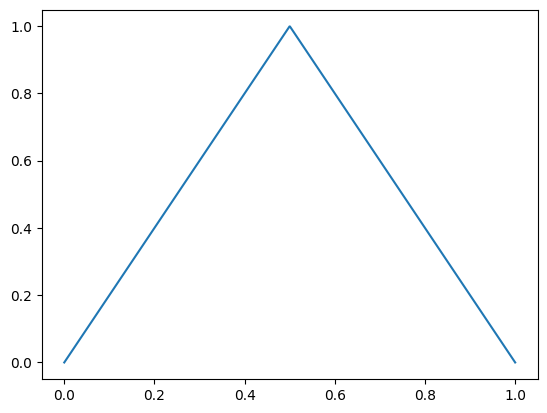

In [2]:
sigma = lambda x: np.maximum(0, x)

def g(x):
    return 2 * sigma(x) - 4 * sigma(x - 1/2)

N = 1000
x =  np.linspace(0, 1, N)
plt.figure()
plt.plot(x, g(x));

### Exercise

{exercise}
- Construct a function that implements $g_n$ for $n\geq1$, with $g_1=g$ and $g_n = g \circ g_{n-1}$ for $n\geq2$. 
- Run the validation test below &mdash; you should obtain the same functions as on page 2 of the lecture notes.

In [3]:
def g_n(x, n):
    if n==1:
        result=g(x)
    else:
        result = g(g_n(x,n-1))
    return result

### Validation

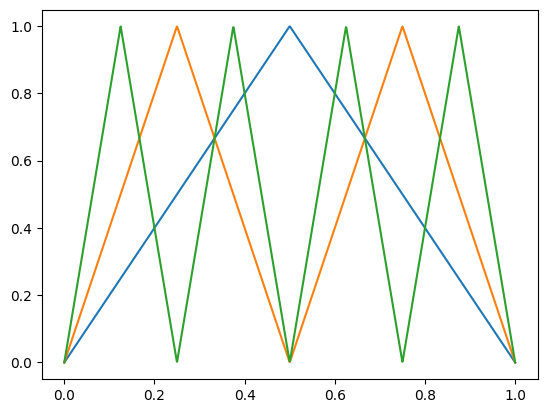

In [4]:
x =  np.linspace(0, 1, 1000)
nmax = 3
plt.figure()
for n in range(1, nmax + 1):
    plt.plot(x, g_n(x, n))

## 1.2 Approximating the square

Define for $x\in[0,1]$

$$
f(x) = x^2, \qquad \hat{f}_n(x) = x - \sum_{j=1}^n\frac{g_j(x)}{4^j}.
$$

We showed in the lecture that

$$
\Vert f - \hat{f}_n\Vert_\infty \leq \frac{1}{3}\frac{1}{4^n}.
$$

It is actually possible to prove convergence at a faster rate $1/4^{n+1}$.

### Exercise

{exercise}
- Construct a function that implements $\hat{f}_n$ for $n\geq1$. 
- Run the validation test below &mdash; you should obtain convergence at the theoretical sharp rate $1/4^{n+1}$.

In [5]:
def f_n(x, n):
    result = 0
    for j in range(1,n+1):
        if (1/(4)**j<=1e-16):
            break
        result+=g_n(x,j)/(4)**j
    return x - result

### Validation

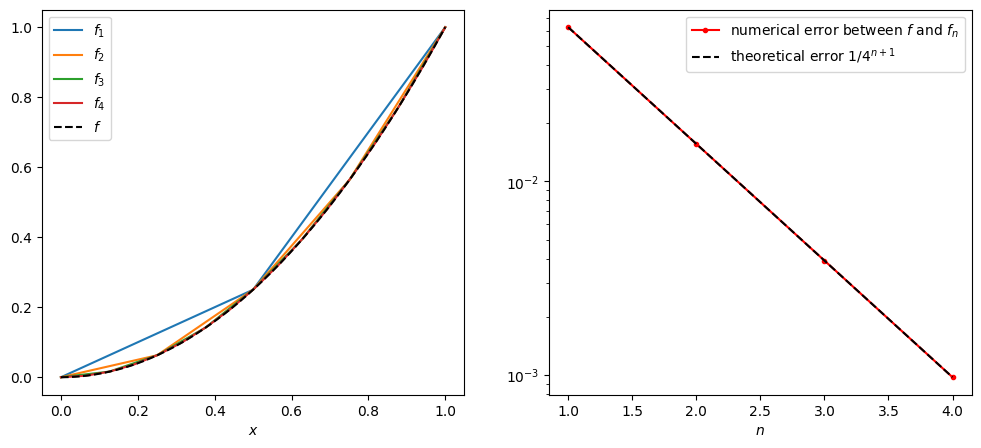

In [6]:
# Exact square:
f = lambda x: x**2

# Grid for computing errors and plotting:
x =  np.linspace(0, 1, 1000)

# Plot f_n and error for increasing n:
nmax = 4
nn = np.arange(1, nmax + 1)
e = np.zeros(nmax)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for n in range(1, nmax + 1):
    axs[0].plot(x, f_n(x, n), label=f"$f_{n}$")
    e[n-1] = np.max(np.abs(f(x) - f_n(x, n)))
    
axs[0].plot(x, f(x), '--k', label="$f$")
axs[0].set_xlabel('$x$')
axs[0].legend()
axs[1].semilogy(nn, e, '.-r', label='numerical error between $f$ and $f_n$') 
axs[1].semilogy(nn, 1/4**(nn+1), '--k', label='theoretical error $1/4^{n+1}$')
axs[1].set_xlabel('$n$')
plt.legend();

## 1.3 Approximating the product of two inputs

### Exercise

{exercise}
- Construct a function that implements the approximate product $xy$ using $\hat{f}_n$ via

$$
\widehat{\Pi}(x,y) = \hat{f}_n\left(\frac{\sigma(x+y)}{2} + \frac{\sigma(-x-y)}{2}\right) - \hat{f}_n\left(\frac{\sigma(x-y)}{2} + \frac{\sigma(y-x)}{2}\right).
$$
- Run the validation test bellow &mdash; it should display True.

In [7]:
def product(x, y, n):
    a=sigma(x+y)/2+sigma(-x-y)/2
    b=sigma(x-y)/2+sigma(y-x)/2
    return f_n(a,n)-f_n(b,n)

### Validation

In [8]:
x = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, x)
Z = X * Y

epsilon = 1e-8
n = int(np.ceil(np.log(2/epsilon)/np.log(4) - 1))
np.max(np.abs(Z - product(X, Y, n))) < epsilon

True

# 2 Convergence rates in Sobolev spaces

## 2.1 Partition of unity

For $L\geq1$, define

$$ 
\phi_\ell(x) = \psi\Big(3L\Big(x-\frac{\ell}{L}\Big)\Big), \qquad \psi(x) = \sigma(x+2) + \sigma(x-2) - \sigma(x+1) - \sigma(x-1), \qquad 1\leq\ell\leq L.
$$

### Exercise

{exercise}
- Construct a function that implements $\phi_\ell$.
- Run the validation test below &mdash; you should obtain the same functions as on page 5 of the lecture notes.

In [9]:
psi = lambda x: sigma(x+2) + sigma(x-2) - sigma(x+1) - sigma(x-1)

def phi_l(x, l, L):
    return psi(3*L*(x-l/L))

### Validation

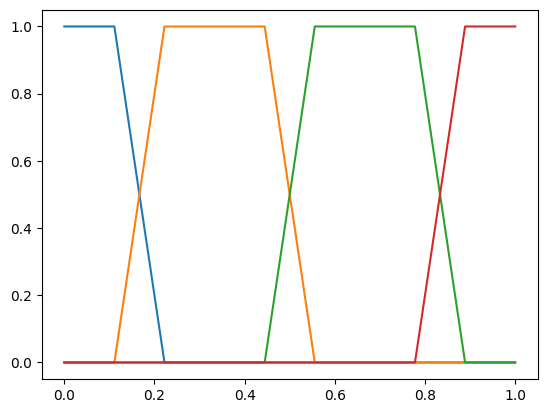

In [10]:
x =  np.linspace(0, 1, 1000)
L = 3
for l in range(L + 1):
    plt.plot(x, phi_l(x, l, L))

## 2.2 Sum-products of local Taylor polynomials

For $s\geq1$ and $L\geq 1$, define

$$
f_L(x) = \sum_{\ell=0}^L \phi_\ell(x)P_\ell(x) \qquad \text{with} \qquad P_\ell(x) = \sum_{j=0}^{s-1} \frac{f^{(j)}(\frac{\ell}{L})}{j!}\Big(x-\frac{\ell}{L}\Big)^j.
$$

We showed in the lecture that

$$
\Vert f - f_L\Vert \leq \frac{2}{s!}\left(\frac{1}{L}\right)^s,
$$

for functions in $W^{s,\infty}([0,1])$.

### Exercise

{exercise}
- Construct a function that implements $f_L$ for functions $f$ of the form

$$
f(x) = \vert x - 0.5\vert^s,
$$

for some $s\geq 1$. We note that, for odd $s$, these functions $f$ are in $W^{s,\infty}([0,1])$. 
- Run the validation code &mdash; you should obtain convergence at the theoretical rate $2/s!(1/L)^s$.

In [11]:

def f_deriv(j, x, s):
    
    if x==0.5:
        return 0.0
        
    if x < 0.5:
        sign_factor = (-1)**j
        dist = 0.5 - x
    else:
        sign_factor = 1
        dist = x - 0.5

    if j > s:
        return 0.0

    coeff = 1
    for m in range(j):
        coeff *= (s - m)
    return sign_factor * coeff * dist**(s-j)


def P_l(x, l, L, s):
    result = 0
    for j in range(s):
        result += f_deriv(j, l/L, s)*(x - l/L)**j / factorial(j)
    return result

def f_L(x, L, s):
    result = 0
    for l in range(L+1):
        result += phi_l(x, l, L) * P_l(x, l, L, s)
    return result

### Validation

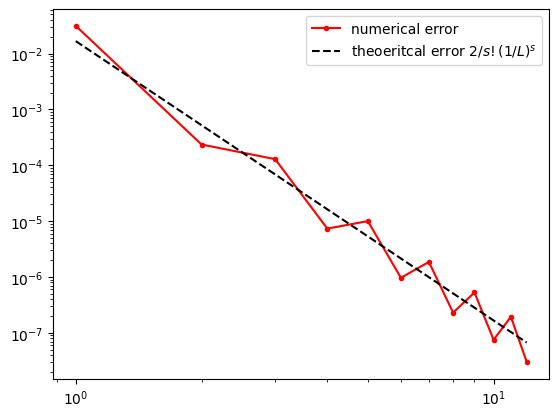

In [12]:
# Grid for computing errors and plotting:
x = np.linspace(0, 1, 1000)

# Function f:
s = 5
f = lambda x: np.abs(x - 0.5)**s

# Loop over L:
Lmax = 12
LL = np.arange(1, Lmax + 1)
e = np.zeros(Lmax)
for L in LL:
    e[L-1] = np.max(np.abs(f(x) - f_L(x, L, s)))
    
plt.figure()
plt.loglog(LL, e, '.-r', label='numerical error')
plt.loglog(LL, 2/factorial(s)*1/LL**s, '--k', label="theoeritcal error $2/s!(1/L)^s$")
plt.legend();

## 2.3 Approximating sum-products of local Taylor polynomials

We define our neural network approximation via

$$
\hat{f}_L(x) = \sum_{\ell=0}^L \widehat{\Pi}(\phi_l(x),\widehat{P}_l(x)) \qquad \text{with} \qquad \widehat{P}_\ell(x) = \sum_{j=0}^{s-1} \frac{f^{(j)}(\frac{\ell}{L})}{j!}\widehat{\Pi}\Big(\underbrace{x-\frac{\ell}{L},\ldots,x-\frac{\ell}{L}}_{\text{$j$ times}}\Big).
$$

### Exercise

{exercise}
- Construct a function that implements $\hat{f}_L$ for functions $f$ of the form

$$
f(x) = \vert x - 0.5\vert^s, \qquad s\geq 1.
$$

- Run the validation code &mdash; you should obtain convergence at the same theoretical rate $2/s!(1/L)^s$

In [13]:
def Phat_l(x, L, s, l, n):
    result = 0
    product_j=1
    for j in range(s):
        result += f_deriv(j, l/L, s)*product_j/ factorial(j)
        product_j =product( product_j, x-l/L, n)
    return result

def fhat_L(x, L, s, n):
    result = 0
    for l in range(L+1):
        result += product(phi_l(x, l, L), Phat_l(x, L, s, l, n), n)
    return result
  


### Validation

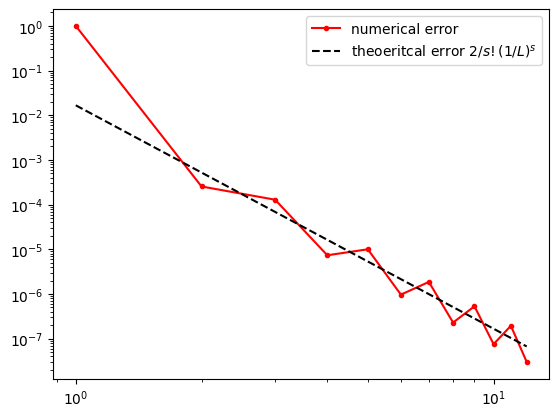

In [14]:
# Grid for computing errors and plotting:
# x=0.2
# l=4
# L=20
# n=100
# s=9

# Phat_l(x, L, s, l, n), P_l(x, l, L, s)
x = np.linspace(0, 1, 1000)

# Function f:
s = 5
f = lambda x: np.abs(x - 0.5)**s

# Loop over L:
Lmax = 12
LL = np.arange(1, Lmax + 1)
e = np.zeros(Lmax)
for L in LL:
    n = ceil(L*log(L**s)) # the size is L * log(1/eps) = L * L^s
    e[L-1] = np.max(np.abs(f(x) - fhat_L(x, L, s, n)))
    
plt.figure()
plt.loglog(LL, e, '.-r', label='numerical error')
plt.loglog(LL, 2/factorial(s)*1/LL**s, '--k', label="theoeritcal error $2/s!(1/L)^s$")
plt.legend();

# Lecture questions (Chapter 1)

{exercise 7}
Prove Theorem 2 of Chapter 1.

{exercise 8}
Prove that Gauss-Newton's method corresponds to Newton's method where the Hessian at step $k$ has been replaced by $(J^k)^T(J^k)$.

# Lecture questions (Chapter 2)

{exercise 9}
Prove Lemma 1 of Chapter 2.

{exercise 10}
Prove the formulas at the end of equations (40), (41), and (42) of Chapter 2, for example:

$$
\left(\frac{\partial\bm{z}^{(\ell)}}{\partial\bm{z}^{(\ell-1)}}\right)_{ij} = W_{ij}^{(\ell)}\sigma'(\bm{z}^{(\ell-1)})_j.
$$

# Lecture questions (Chapter 3)

{exercise 11}
Show that polynomials satisfy the assumptions of of Theorem 1 of Chapter 3, but neural networks do not.

{exercise 12}
Prove the property in equation (12) of Chapter 3.

{exercise 13}
Show that the $\phi_\ell$'s are a partition of unity.

{exercise 14}
Show that the approximation error in equation (15) of Chapter 3 can be improved to $1/4^{n+1}$. *(Challenging & optional.)* 